# <center><font color='blue'>SENTIMENT ANALYSIS: COVID</center></font>

## Taba de contenido
- [1 - Objetivos](#1)
- [2 - Librerías necesarias](#2)
- [3 - Carga y visualización de datos](#3)
- [4 - Pre-procesamiento de datos](#4)
    - [4.1. - Datos faltantes](#4.1)
    - [4.2. - Data Categóricos](#4.2)
    - [4.3. - Pre-Procesamiento especial para NLP](#4.3)
- [5 - Modelo](#5)
- [6 - Ajuste de hiperparámetros](#6)
- [7 - Conclusiones](#7)
- [8 - Referencias](#8)

<a name="1"></a>
## 1. Objetivos

Practicarse con un problema de procesamiento del lenguaje natural.
<br>
Aquí, dado un conjunto de tweets, analizar si el sentimiento es positivo o negativo

<a name="2"></a>
## 2. Librerías necesarias

In [40]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt



<a name="3"></a>
## 3. Carga y visualización de datos

Tenemos 2 datasets, uno para entrenamiento y otro para test:

In [3]:
train_data_pandas = pd.read_csv('data/Corona_NLP_train.csv',encoding='latin-1')
test_data_pandas = pd.read_csv('data/Corona_NLP_test.csv',encoding='latin-1')

Vemos por ejemplo los datos de entrenamiento

In [4]:
train_data_pandas.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Chequeamos test

In [5]:
test_data_pandas.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


<a name="4"></a>
## 4. Pre-procesamiento de datos

<a name="4.1."></a>
### 4.1. Datos faltantes

In [7]:
print(f'Datos faltantes train:\n {train_data_pandas.isnull().sum()} \n')
print(f'Datos faltantes test:\n {test_data_pandas.isnull().sum()}')

Datos faltantes train:
 UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64 

Datos faltantes test:
 UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


Vemos que no hay datos faltantes en las columnas que nos interesan (OriginalTweet y Sentiment).

<a name="4.2"></a>
### 4.2. Datos categóricos 

Nos interesaremos en las columnas OriginalTweet y Sentiment; a su vez veremos las distintas opciones de esta última columna:

In [9]:
train_data_pandas['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

Convertiremos esta columna a valores numéricos; a su vez no nos interesa ser tan específicos respecto a si un sentimiento es postivo o extremadamente positivo, más bien distinguiremos entre positivo y negativo. Los neutrales los consideraremos positivos. 

In [10]:
label_map = {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':1,'Extremely Positive':1}
train_data_pandas['Sentiment'] = train_data_pandas['Sentiment'].map(label_map)
test_data_pandas['Sentiment'] = test_data_pandas['Sentiment'].map(label_map)

Chequeamos

In [11]:
train_data_pandas.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


<a name="4.3"> </a>
### 4.3. Pre-procesamiento especial para NLP

Vamos a pe-procesar el texto de OriginalTweet, para ello:


- Quitaremos las stop-words
- Quitaremos algunos caracteres especiales, como "@"
- Aplicaremos Lemmatization


<b>Nota:</b> Habría que quitar también las puntuaciones, llevar todo a minúscula y tokenizar, pero eso lo haremos luego con TextVectorization.


Descargaremos e imprimiremos para ver las stop words:

In [13]:
nltk.download('stopwords')
# View stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/marcos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


También necesitaremos "punkt" y "wordnet":

In [14]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/marcos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marcos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Quitamos las stop words y aplicaremos la lematización:

In [15]:
# Inicializar lematizador
lemmatizer = WordNetLemmatizer()

# stop words
stop_words = set(stopwords.words('english'))

# Función para quitar palabras de parada y lematizar un texto
def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Aplicar la función a la columna 'OriginalTweet' del dataset, tanto en train como test
train_data_pandas['OriginalTweet'] = train_data_pandas['OriginalTweet'].apply(preprocess_text)
test_data_pandas['OriginalTweet'] = test_data_pandas['OriginalTweet'].apply(preprocess_text)


Además vamos a eliminar caracteres especiales, como @ y # (me quedaré con otros, como "!", pues pueden ser importantes para el significado).

In [16]:
# Eliminar arrobas en direcciones de correo electrónico o menciones
def preprocess_text2(text):
    return re.sub(r'[@#]', '', text) #&

# lo aplicamos
train_data_pandas['OriginalTweet'] = train_data_pandas['OriginalTweet'].apply(preprocess_text2)
test_data_pandas['OriginalTweet'] = test_data_pandas['OriginalTweet'].apply(preprocess_text2)



Veamos cómo quedaron los datos:

In [19]:
train_data_pandas['OriginalTweet']

0         menyrbie  phil_gahan  chrisitv http : //t.co/...
1        advice talk neighbour family exchange phone nu...
2        coronavirus australia : woolworth give elderly...
3        food stock one empty ... please , n't panic , ...
4        , ready go supermarket  covid19 outbreak . 'm ...
                               ...                        
41152    airline pilot offering stock supermarket shelf...
41153    response complaint provided citing covid-19 re...
41154    know itâs getting tough  kameronwilds rationi...
41155    wrong smell hand sanitizer starting turn ?  co...
41156     tartiicat well new/used rift going $ 700.00 a...
Name: OriginalTweet, Length: 41157, dtype: object

Vamos ahora a crear los datasets para trabajar con tensorflow

In [20]:
# Cargar el DataFrame de pandas en un objeto tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_pandas['OriginalTweet'].values, 
                                              train_data_pandas['Sentiment'].values))


In [21]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b' menyrbie  phil_gahan  chrisitv http : //t.co/ifz9fan2pa http : //t.co/xx6ghgfzcc http : //t.co/i2nlzdxno8'
label:  1


Repetimos para test:

In [22]:
# Cargar el DataFrame de pandas en un objeto tf.data.Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_pandas['OriginalTweet'].values, 
                                                   test_data_pandas['Sentiment'].values))


Definimos el tamaño del buffer y del lote:

In [23]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [24]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Veamos algunos ejemplos y sus etiquetas

In [25]:
for example, label in train_dataset.take(1):
  print(f'texts:  {example.numpy()[:3]}\n')
  print(f'labels: , {label.numpy()[:3]}')

texts:  [b'food bank forced close amid coronavirus outbreak http : //t.co/chgunzpp4w independent  corona  wiwt  covid19  friday  update   tbt'
 b'yes empty shelf novelty sharing hundred picture helping mass anxiety supply chain consider sharing'
 b"sainsbury 's asda limit sale food item http : //t.co/auswdhjfgv  shopping  supermarket  coronavirus"]

labels: , [0 1 1]


Ahora crearemos y aplicaremos una capa llamada <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization" target='_blanck'>TextVectorization</a>, que quitará las puntuaciones, pasará todo a minúsculas y tokenizará:


In [26]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

encoder.adapt(train_dataset.map(lambda text, label: text))

A continuación se muestran los primeros 20 tokens:


In [27]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'http', 'coronavirus', 'covid19', 'price', 'store',
       'supermarket', 'food', 'grocery', 'people', 'amp', 'consumer',
       '19', 'covid', 'shopping', 's', 'online', 'need', 'pandemic'],
      dtype='<U19')

Ahora que el vocabulario está configurado, la capa puede codificar el texto en índices. Los tensores de índices son rellenados con 0s para que tengan el tamaño de la secuencia más larga en el lote.

Veamos un ejemplo:

In [30]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  8, 118, 754, 208,  99,   3,  77,   2,   1,   1, 137,   1,   4,
          1, 220,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [565, 156,  57,   1,   1,   1, 902, 367, 835, 756,  35, 116, 604,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  1,  16, 616, 338, 174,   8, 101,   2,   1,  15,   7,   3,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]])

Con esta configuración, el proceso no es completamente reversible.


In [31]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'food bank forced close amid coronavirus outbreak http : //t.co/chgunzpp4w independent  corona  wiwt  covid19  friday  update   tbt'
Round-trip:  food bank forced close amid coronavirus outbreak http [UNK] [UNK] corona [UNK] covid19 [UNK] update [UNK]               

Original:  b'yes empty shelf novelty sharing hundred picture helping mass anxiety supply chain consider sharing'
Round-trip:  yes empty shelf [UNK] [UNK] [UNK] picture helping mass anxiety supply chain consider [UNK]                 

Original:  b"sainsbury 's asda limit sale food item http : //t.co/auswdhjfgv  shopping  supermarket  coronavirus"
Round-trip:  [UNK] s asda limit sale food item http [UNK] shopping supermarket coronavirus                   



Puede observarse que hay muchos tokens desconocidos ([UNK])

<a name="5"></a>
## 5. MODELO

Definimos el modelo, la arquitectura se muestra en la figura siguiente:


<img src="images/Model.png"/>



In [32]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

La capa de embedding usa enmascaramiento para manejar secuencias de longitud variable. Todas las capas después de la de embedding soportan enmascaramiento.


In [33]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Sentencias de prueba

In [34]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


1/1 [==============================] - 2s 2s/step
[-0.00894204]


In [35]:
# con una sentencia más larga
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


1/1 [==============================] - 0s 176ms/step
[-0.00894203]


Vemos que el modelo devuelve como predicción un número real.

Compilamos; como es un problema con 2 clases usamos BinaryCrossentrpy.

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

Implementaremos Learning Rate Scheduler


In [37]:
# Definir una función que devuelve la tasa de aprendizaje en función de las épocas
def learning_rate_scheduler(epoch):
    initial_lr = 1e-4
    decay_factor = 0.9
    decay_steps = 3
    new_lr = initial_lr * decay_factor ** (epoch // decay_steps)
    return new_lr # Forzar la conversión a float


Entrenamos durante 10 epochs

In [38]:
# Definir el callback de LearningRateScheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

history = model.fit(
                    train_dataset, 
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    callbacks=[lr_scheduler])

Epoch 1/10
644/644 [==============================] - 24s 27ms/step - loss: 0.5954 - accuracy: 0.6040 - val_loss: 0.5497 - val_accuracy: 0.7177 - lr: 1.0000e-04
Epoch 2/10
644/644 [==============================] - 15s 23ms/step - loss: 0.4521 - accuracy: 0.7852 - val_loss: 0.5035 - val_accuracy: 0.7542 - lr: 1.0000e-04
Epoch 3/10
644/644 [==============================] - 15s 23ms/step - loss: 0.4270 - accuracy: 0.8021 - val_loss: 0.4946 - val_accuracy: 0.7646 - lr: 1.0000e-04
Epoch 4/10
644/644 [==============================] - 15s 23ms/step - loss: 0.4187 - accuracy: 0.8069 - val_loss: 0.4964 - val_accuracy: 0.7693 - lr: 9.0000e-05
Epoch 5/10
644/644 [==============================] - 15s 23ms/step - loss: 0.4150 - accuracy: 0.8102 - val_loss: 0.4844 - val_accuracy: 0.7521 - lr: 9.0000e-05
Epoch 6/10
644/644 [==============================] - 15s 23ms/step - loss: 0.4134 - accuracy: 0.8104 - val_loss: 0.4879 - val_accuracy: 0.7693 - lr: 9.0000e-05
Epoch 7/10
644/644 [==============

Evaluamos

In [39]:
test_loss, test_acc = model.evaluate(test_dataset)


60/60 [==============================] - 1s 9ms/step - loss: 0.4729 - accuracy: 0.7762


Graficaremos:

In [42]:
# Función auxiliar para graficar
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6048526868224144)

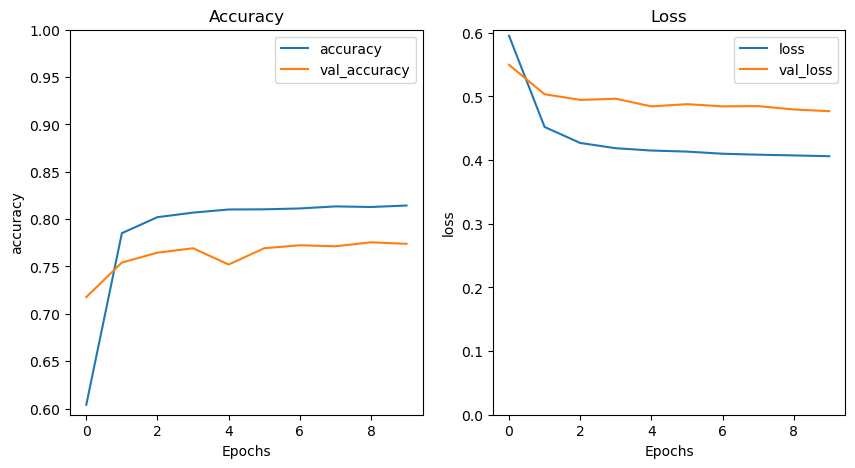

In [43]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Loss')
plt.ylim(0, None)


<a name="6"></a>
## 6. AJUSTE DE HIPERPARÁMETROS

Cambiaremos la arqutectura del modelo (usaremos 2 LSTMs bidireccionales)


El nuevo modelo es el siguiente:


<img src="images/new_model.png"/>

In [44]:
new_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


Volvemos a compilar y entrenar:

In [45]:
new_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])


history = new_model.fit(
                    train_dataset, 
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    callbacks=[lr_scheduler])

Epoch 1/10
644/644 [==============================] - 48s 55ms/step - loss: 0.5982 - accuracy: 0.5916 - val_loss: 0.5492 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 2/10
644/644 [==============================] - 30s 46ms/step - loss: 0.4566 - accuracy: 0.7808 - val_loss: 0.4978 - val_accuracy: 0.7615 - lr: 1.0000e-04
Epoch 3/10
644/644 [==============================] - 33s 51ms/step - loss: 0.4303 - accuracy: 0.8003 - val_loss: 0.5150 - val_accuracy: 0.7688 - lr: 1.0000e-04
Epoch 4/10
644/644 [==============================] - 34s 53ms/step - loss: 0.4212 - accuracy: 0.8068 - val_loss: 0.4817 - val_accuracy: 0.7781 - lr: 9.0000e-05
Epoch 5/10
644/644 [==============================] - 33s 51ms/step - loss: 0.4168 - accuracy: 0.8091 - val_loss: 0.4806 - val_accuracy: 0.7786 - lr: 9.0000e-05
Epoch 6/10
644/644 [==============================] - 34s 52ms/step - loss: 0.4140 - accuracy: 0.8126 - val_loss: 0.4836 - val_accuracy: 0.7745 - lr: 9.0000e-05
Epoch 7/10
644/644 [==============

In [47]:
test_loss, test_acc = new_model.evaluate(test_dataset)

60/60 [==============================] - 1s 19ms/step - loss: 0.4760 - accuracy: 0.7620


(0.0, 0.6078906804323196)

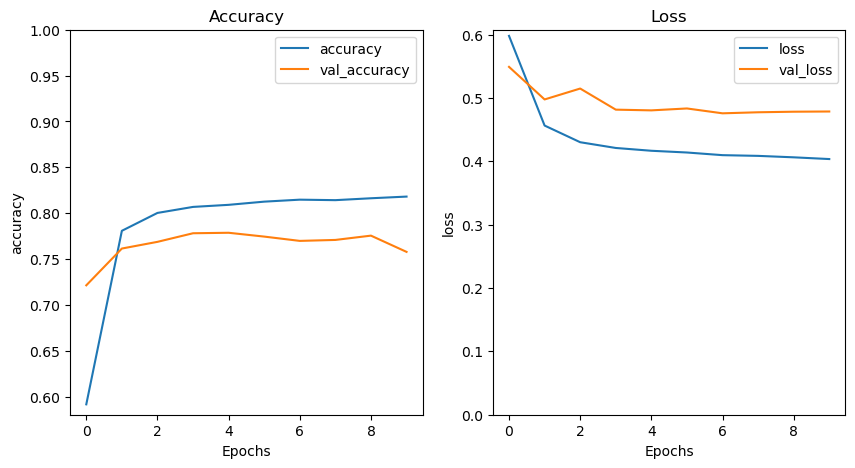

In [48]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Loss')
plt.ylim(0, None)

<a name="7"></a>
## 7. CONCLUSIONES

Se entrenó un modelo con una precisión del 77% para detectar el sentimiento en tweets respeto al COVID. Para mejorarlo podríamos por ejemplo ampliar el tamaño del vocabulario o cambiar la arquitectura del modelo.

<a name="8"><a/>
# 8. REFERENCIAS

- <a href="https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=es-419">Text classification with an RNN</a>
- <a href="https://www.coursera.org/specializations/natural-language-processing">Programa especializado NLP (Coursera)</a>